In [1]:
from enum import Enum
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def visualize_v_grid(v_grid, env):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Convert V_grid to numpy array for easier manipulation
    v_array = np.array(v_grid)
    
    # Create a mask for zero values (non-accessible states)
    zero_mask = v_array == 0.0
    
    # Create a custom colormap
    cmap = plt.cm.YlGn.copy()
    cmap.set_bad(color='gray')
    
    # Create heatmap
    v_array_masked = np.ma.masked_where(zero_mask, v_array)
    im = ax.imshow(v_array_masked, cmap=cmap)
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")
    
    # Add text annotations
    for i in range(v_array.shape[0]):
        for j in range(v_array.shape[1]):
            if zero_mask[i, j]:
                text = ax.text(j, i, 'X', ha="center", va="center", color="white", fontweight='bold')
            else:
                text = ax.text(j, i, f'{v_array[i, j]:.3f}',
                               ha="center", va="center", color="black")
    
    # Set tick labels
    ax.set_xticks(np.arange(v_array.shape[1]))
    ax.set_yticks(np.arange(v_array.shape[0]))
    ax.set_xticklabels(range(v_array.shape[1]))
    ax.set_yticklabels(range(v_array.shape[0]))
    
    # Add grid
    ax.set_xticks(np.arange(-0.5, v_array.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, v_array.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", va="center")
    
    # Add title
    ax.set_title("Value Function Heatmap")
    
    # Show plot
    plt.tight_layout()
    plt.show()


In [3]:
class State():

    def __init__(self, row=-1, column=-1):
        self.row = row
        self.column = column

    def __repr__(self):
        return "<State: [{}, {}]>".format(self.row, self.column)

    def clone(self):
        return State(self.row, self.column)

    def __hash__(self):
        return hash((self.row, self.column))

    def __eq__(self, other):
        return self.row == other.row and self.column == other.column

In [4]:
class Action(Enum):
    UP = 1
    DOWN = -1
    LEFT = 2
    RIGHT = -2

In [5]:
class Environment():

    def __init__(self, grid, move_prob=0.8):
        # grid is 2d-array. Its values are treated as an attribute.
        # Kinds of attribute is following.
        #  0: ordinary cell
        #  -1: damage cell (game end)
        #  1: reward cell (game end)
        #  9: block cell (can't locate agent)
        self.grid = grid
        self.agent_state = State()

        # Default reward is minus. Just like a poison swamp.
        # It means the agent has to reach the goal fast!
        self.default_reward = -0.04

        # Agent can move to a selected direction in move_prob.
        # It means the agent will move different direction
        # in (1 - move_prob).
        self.move_prob = move_prob
        self.reset()

    #グリッドの行数を計算
    @property
    def row_length(self):
        return len(self.grid)

    #グリッドの列数を計算
    @property
    def column_length(self):
        return len(self.grid[0])

    #可能な行動
    @property
    def actions(self):
        return [Action.UP, Action.DOWN,
                Action.LEFT, Action.RIGHT]

    #状態
    @property
    def states(self):
        states = []
        for row in range(self.row_length):
            for column in range(self.column_length):
                # Block cells are not included to the state.
                if self.grid[row][column] != 9:
                    states.append(State(row, column))
        return states

    #遷移関数
    def transit_func(self, state, action):
        transition_probs = {}
        if not self.can_action_at(state):
            # Already on the terminal cell.
            return transition_probs

        opposite_direction = Action(action.value * -1)

        for a in self.actions:
            prob = 0
            if a == action:
                prob = self.move_prob
            elif a != opposite_direction:
                #実際には右側に行った方が行動としてはいいよね
                #だから，左右に行く確率は0.1ずつ変える
                #行動は辞書型で定義されている
                #これ行動によって変わっているので実際には左右みたいな感じでできない
                # if a == Action.UP or a == Action.DOWN:
                #     prob = (1 - self.move_prob) * 0.5
                
                # elif a == Action.RIGHT or a == Action.LEFT:
                #     if a == Action.RIGHT:
                #         prob = (1 - self.move_prob) * 0.7
                #     elif a == Action.LEFT:
                #         prob = (1 - self.move_prob) * 0.3

                prob = (1 - self.move_prob) / 2

            next_state = self._move(state, a)
            if next_state not in transition_probs:
                transition_probs[next_state] = prob
            else:
                transition_probs[next_state] += prob

            
        #遷移関数の値を1にしてみる


        # print(transition_probs)
        return transition_probs

    def can_action_at(self, state):
        if self.grid[state.row][state.column] == 0:
            return True
        else:
            return False

    def _move(self, state, action):
        if not self.can_action_at(state):
            raise Exception("Can't move from here!")

        next_state = state.clone()

        # Execute an action (move).
        if action == Action.UP:
            next_state.row -= 1
        elif action == Action.DOWN:
            next_state.row += 1
        elif action == Action.LEFT:
            next_state.column -= 1
        elif action == Action.RIGHT:
            next_state.column += 1

        # Check whether a state is out of the grid.
        if not (0 <= next_state.row < self.row_length):
            next_state = state
        if not (0 <= next_state.column < self.column_length):
            next_state = state

        # Check whether the agent bumped a block cell.
        if self.grid[next_state.row][next_state.column] == 9:
            next_state = state

        return next_state

    def reward_func(self, state):
        #デフォルトの報酬は-0.04なので，ただ行動するだけではいけない
        reward = self.default_reward
        done = False

        # Check an attribute of next state.
        attribute = self.grid[state.row][state.column]
        if attribute == 1:
            # Get reward! and the game ends.
            reward = 1
            done = True
        elif attribute == -1:
            # Get damage! and the game ends.
            reward = -1
            done = True

        return reward, done

    def reset(self):
        # Locate the agent at lower left corner.
        self.agent_state = State(self.row_length - 1, 0)
        return self.agent_state

    def step(self, action):
        # print(action)
        next_state, reward, done = self.transit(self.agent_state, action)
        if next_state is not None:
            self.agent_state = next_state

        return next_state, reward, done

    def transit(self, state, action):
        transition_probs = self.transit_func(state, action)
        if len(transition_probs) == 0:
            return None, None, True

        next_states = []
        probs = []
        for s in transition_probs:
            next_states.append(s)
            probs.append(transition_probs[s])

        next_state = np.random.choice(next_states, p=probs)
        reward, done = self.reward_func(next_state)
        return next_state, reward, done

In [6]:
class Agent():

    def __init__(self, env):
        self.actions = env.actions

    #方策の定義
    def policy(self, state):
        '''
            価値反復法における方策は意味をなさない．なぜならこの学習方法はモデルベースの方法かつValueベースの考えてであるため
            実際の行動はその状態における価値が最大となる行動を選択する．
            よってそれを実装していく．
        '''
        return random.choice(self.actions)

In [7]:
class Planner():

    def __init__(self, env):
        self.env = env
        self.log = []

    def initialize(self):
        self.env.reset()
        self.log = []

    def plan(self, gamma=0.9, threshold=0.0001):
        raise Exception("Planner have to implements plan method.")

    #　遷移関数の定義
    def transitions_at(self, state, action):
        transition_probs = self.env.transit_func(state, action)
        for next_state in transition_probs:
            prob = transition_probs[next_state]
            reward, _ = self.env.reward_func(next_state)
            yield prob, next_state, reward

    def dict_to_grid(self, state_reward_dict):
        grid = []
        #　グリッドの中身を初期化，正確にはグリッドの形をした配列を作成
        for i in range(self.env.row_length):
            row = [0] * self.env.column_length
            grid.append(row)
        # 各状態における報酬をグリッドに反映
        for s in state_reward_dict:
            grid[s.row][s.column] = state_reward_dict[s]

        return grid

In [8]:
class ValueIterationPlanner(Planner):

    def __init__(self, env):
        super().__init__(env)

    def plan(self, gamma=0.9, threshold=0.0001):
        self.initialize()
        actions = self.env.actions
        V = {}
        for s in self.env.states:
            # Initialize each state's expected reward.
            V[s] = 0

        while True:
            delta = 0
            self.log.append(self.dict_to_grid(V))
            for s in V:
                if not self.env.can_action_at(s):
                    continue
                expected_rewards = []
                for a in actions:
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        r += prob * (reward + gamma * V[next_state])
                    expected_rewards.append(r)
                max_reward = max(expected_rewards)
                delta = max(delta, abs(max_reward - V[s]))
                V[s] = max_reward

            if delta < threshold:
                break
        
        # 各グリッドにおける価値を返す
        V_grid = self.dict_to_grid(V)
        return V_grid

In [9]:
class ValueAgent:
    def __init__(self, env,v_grid):
        self.env = env
        self.actions = env.actions
        self.v_grid = v_grid
        self.gamma = 0.9
    #方策の定義
    '''
    def policy(self, state):
        
        #     価値反復法における方策は意味をなさない．なぜならこの学習方法はモデルベースの方法かつValueベースの考えてであるため
        #     実際の行動はその状態における価値が最大となる行動を選択する．
        #     よってそれを実装していく．
        best_action = None
        best_value = float('-inf')
        actions = self.env.actions
        for a in actions:
            next_state, reward, _ = self.env.transit(self.agent_state, a)
            if next_state is None:
                continue
            r += prob * (reward + self.gamma * V[next_state])

            if value > best_value:
                best_value = value
                best_action = a
    '''

    def policy(self, state):
        best_action = None
        best_value = float('-inf')
        for action in self.env.actions:
            next_states = self.env.transit_func(state, action)
            value = 0
            for next_state, prob in next_states.items():
                reward, _ = self.env.reward_func(next_state)
                value += prob * (reward + self.v_grid[next_state.row][next_state.column])
            if value > best_value:
                best_value = value
                best_action = action
        return best_action


In [26]:
def main():
    # Make grid environment.
    grid = [
        [0, 0, 0, 1],
        [0, 9, 0, -1],
        [0, 0, 0, 0]
    ]
    #env = Environment(grid)
    env = Environment(grid, move_prob=0.5)
    planner = ValueIterationPlanner(env)
    v_grid = planner.plan(gamma=0.9, threshold=0.0001)
    agent = ValueAgent(env, v_grid)

    planner = ValueIterationPlanner(env)
    print("Optimal Value Function:")
    # for row in v_grid:
    #     print(row)

    # print(v_grid)
    # print("---------------------")
    # print(planner)
    visualize_v_grid(v_grid, env)
    
    # Try 10 game.
    for i in range(100):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.policy(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state

        # print("Episode {}: Agent gets {} reward.".format(i, total_reward))

Optimal Value Function:


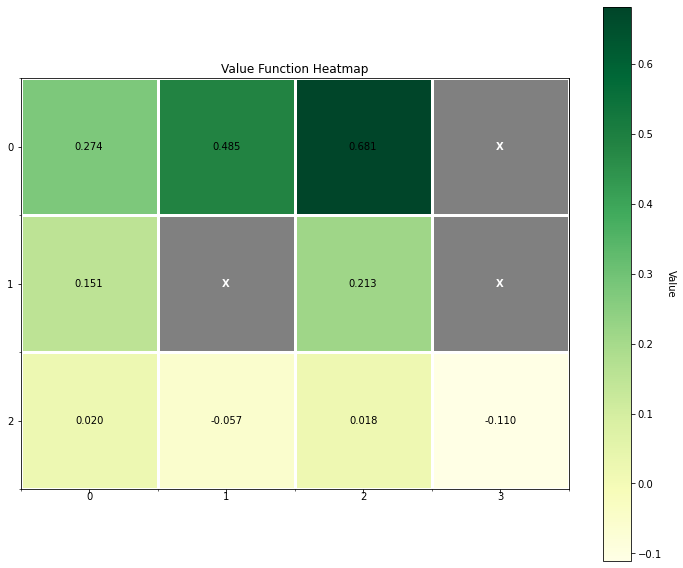

In [27]:
if __name__ == "__main__":
    main()

